In [2]:
%env GOOGLE_APPLICATION_CREDENTIALS=/Users/want/helloworld-6f54947ad8c0.json

env: GOOGLE_APPLICATION_CREDENTIALS=/Users/want/helloworld-6f54947ad8c0.json


In [1]:
from google.cloud import bigquery
from bq_helper import BigQueryHelper
# client = bigquery.Client.from_service_account_json('/Users/want/helloworld-6f54947ad8c0.json')
from matplotlib import pyplot as plt
import matplotlib
from datetime import datetime
import numpy as np
import pandas as pd
%matplotlib inline

# pd.set_option('display.max_colwidth', -1)

def estimate_query_size(q):
    print (str(round((bq_assistant.estimate_query_size(q)),2))+str(" GB"))

bigquery_database = 'bigquery-public-data'
bitcoin_table='bitcoin_blockchain'
block_table = 'blocks'
transction_table = 'transactions'
bq_assistant = BigQueryHelper(bigquery_database, bitcoin_table)
# block_query = """
# SELECT 
# block_id,
# TIMESTAMP_MILLIS(timestamp) as datetime,
# difficultyTarget,
# SUM(outputs.output_satoshis) AS coinbase
# FROM `bigquery-public-data.bitcoin_blockchain.blocks`,
# UNNEST(transactions[OFFSET(0)].outputs) AS outputs 
# GROUP BY block_id,timestamp,difficultyTarget
# ORDER BY timestamp desc
# """

# block_data = bq_assistant.query_to_pandas_safe(block_query,max_gb_scanned=7)
# block_data['coinbase'] = block_data['coinbase'].apply(lambda x: float(x)/10**8)
# block_data.head(5)
# transactions[OFFSET(0)].outputs[OFFSET(0)].output_satoshis AS coinbase,

In [34]:
coinbase_query = """
SELECT 
block_id,
TIMESTAMP_MILLIS(timestamp) as datetime,
difficultyTarget,
SUM(outputs.output_satoshis) AS coinbase
FROM `bigquery-public-data.bitcoin_blockchain.blocks`,
UNNEST(transactions[OFFSET(0)].outputs) AS outputs 
GROUP BY block_id,timestamp,difficultyTarget
ORDER BY timestamp desc
"""
# estimate_query_size(coinbase_query)

# coinbase_info = bq_assistant.query_to_pandas_safe(coinbase_query,max_gb_scanned=76)


75.0 GB


In [108]:
coin_base['date'] = coin_base['date'].apply(lambda x: x.strftime("%Y-%m-%d")) 

In [76]:
query_day_num_block_miner = """
SELECT 
    t.day,
    COUNT(DISTINCT(t.miner_key)) AS num_miner,
    COUNT(DISTINCT(t.block_id)) as num_block
FROM(
    SELECT 
        TIMESTAMP_MILLIS((timestamp - MOD(timestamp,86400000))) AS day,
        o.output_pubkey_base58 as miner_key,
        block_id
    FROM
        `bigquery-public-data.bitcoin_blockchain.blocks`,
        UNNEST(transactions[OFFSET(0)].outputs) AS o
    ) AS t
GROUP BY 
    day
ORDER BY
    day
"""
# estimate_query_size(query_day_num_block_miner)
# day_num_block_miner = bq_assistant.query_to_pandas(query_day_num_miner)

In [51]:
query_miner_ratio = """
SELECT 
    t2.miner_key, count(t2.day) AS count
FROM(
    SELECT
        t.day, t.miner_key, t.block_id
    FROM (
        SELECT 
            TIMESTAMP_MILLIS((timestamp - MOD(timestamp,86400000))) AS day,
            o.output_pubkey_base58 as miner_key,
            block_id
        FROM
            `bigquery-public-data.bitcoin_blockchain.blocks`,
            UNNEST(transactions[OFFSET(0)].outputs) AS o
        ) AS t
    WHERE
        day> TIMESTAMP '2013-10-01 00:00:00+00:00'
    AND 
        day< TIMESTAMP '2015-01-01 00:00:00+00:00'
    ) AS t2
GROUP BY miner_key
"""
bq_assistant

30.0 GB


In [128]:
query_per_block_minerkey = """
SELECT
        t.day, t.miner_key, t.block_id
    FROM (
        SELECT 
            TIMESTAMP_MILLIS((timestamp - MOD(timestamp,86400000))) AS day,
            o.output_pubkey_base58 as miner_key,
            block_id
        FROM
            `bigquery-public-data.bitcoin_blockchain.blocks`,
            UNNEST(transactions[OFFSET(0)].outputs) AS o
        ) AS t
    WHERE
        day> TIMESTAMP '2013-10-01 00:00:00+00:00'
    AND 
        day< TIMESTAMP '2014-03-01 00:00:00+00:00'
"""

# estimate_query_size(query_per_block_minerkey)
block_minerkey = bq_assistant.query_to_pandas(query_per_block_minerkey)

In [137]:
query_all_block_minerkey = """
SELECT
        t.day, t.miner_key, t.block_id
    FROM (
        SELECT 
            TIMESTAMP_MILLIS((timestamp - MOD(timestamp,86400000))) AS day,
            o.output_pubkey_base58 as miner_key,
            block_id
        FROM
            `bigquery-public-data.bitcoin_blockchain.blocks`,
            UNNEST(transactions[OFFSET(0)].outputs) AS o
        ) AS t
"""

# estimate_query_size(query_all_block_minerkey)
# all_block_minerkey = bq_assistant.query_to_pandas(query_all_block_minerkey)

In [7]:
query_day_outputkey_count = """
SELECT
  o.day,
  COUNT(DISTINCT(o.output_key)) AS recipients
FROM (
  SELECT
    TIMESTAMP_MILLIS((timestamp - MOD(timestamp,
          86400000))) AS day,
    output.output_pubkey_base58 AS output_key
  FROM
    `bigquery-public-data.bitcoin_blockchain.transactions`,
    UNNEST(outputs) AS output ) AS o
GROUP BY
  day
ORDER BY
  day
"""
# estimate_query_size(query_outputkey_change)
day_outputkey_count = bq_assistant.query_to_pandas_safe(query_day_outputkey_count,max_gb_scanned=34)

In [26]:
time_format = '%Y-%m-%d'
combined_data['date'] = combined_data['date'].apply(lambda date: datetime.strptime(date,time_format))

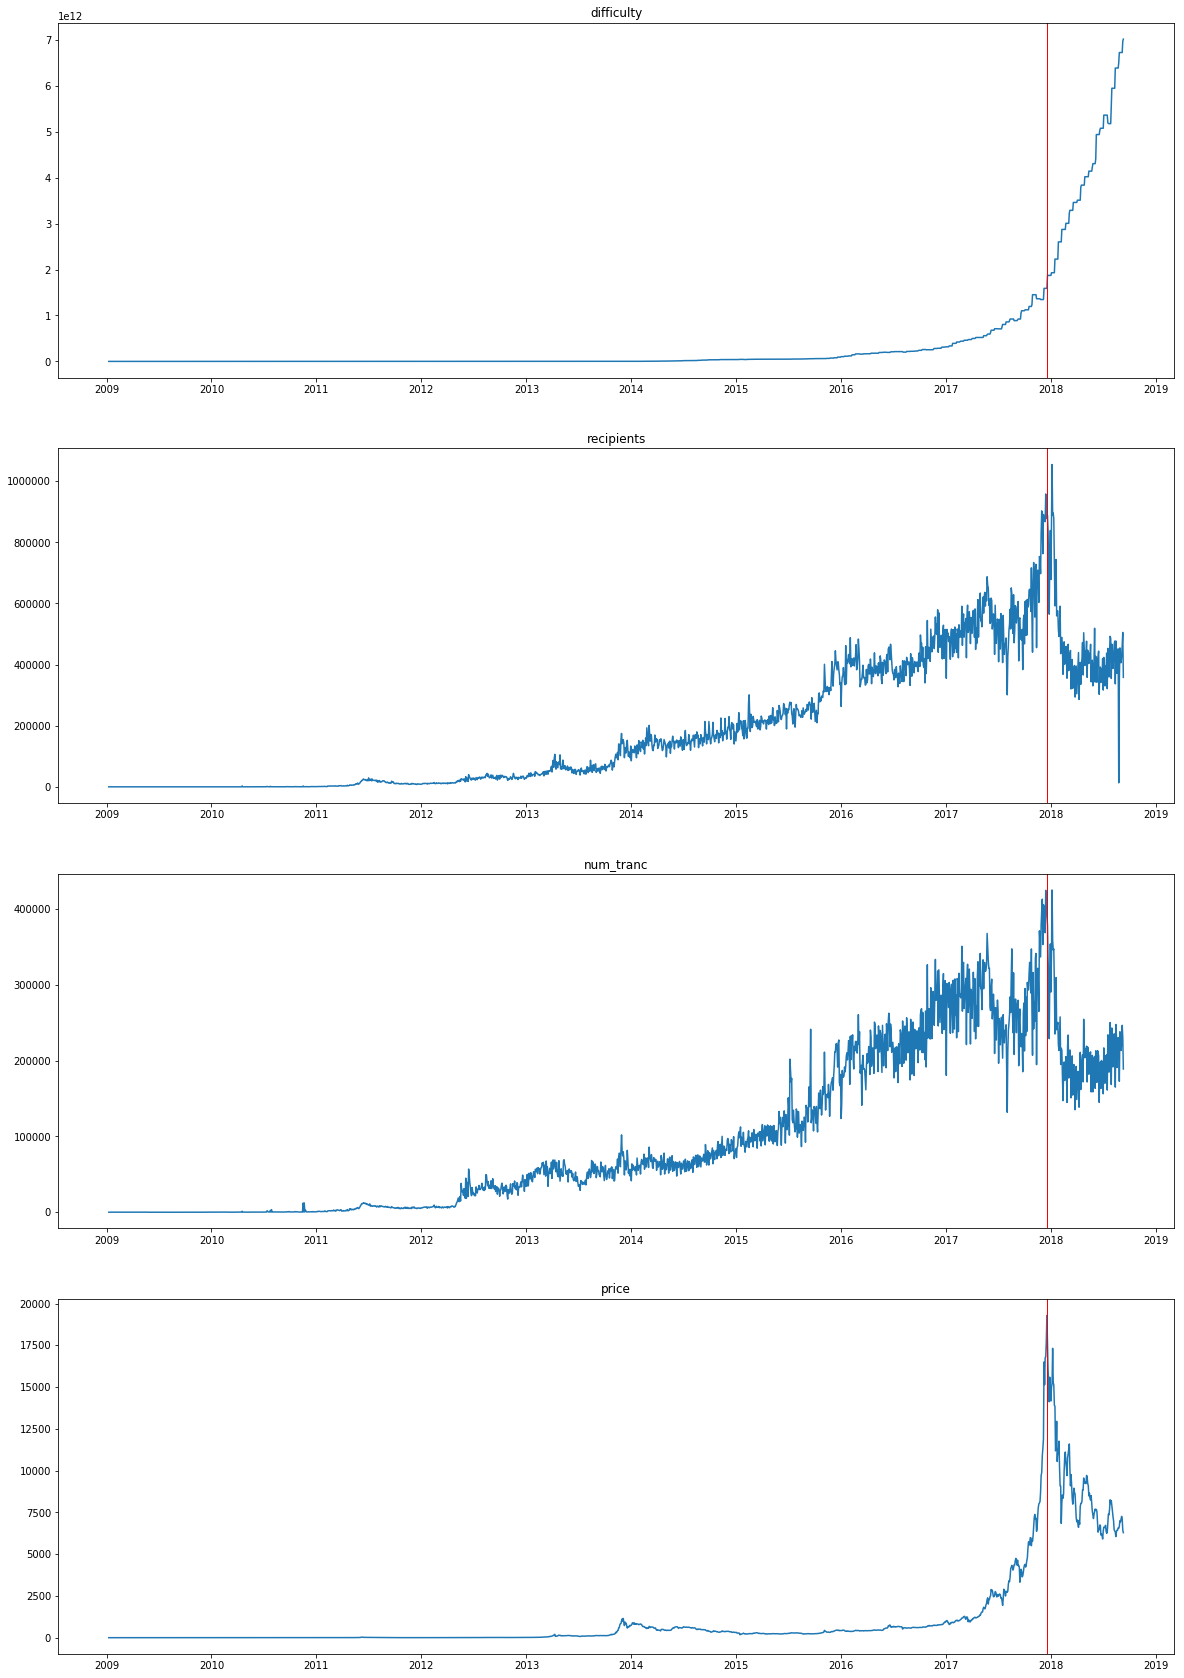

In [32]:
# res = pd.read_csv('./temp_res.csv')
f, axarr = plt.subplots(4,figsize=(20,30))
titles = ['difficulty','recipients','num_tranc','price']
dates = matplotlib.dates.date2num(combined_data['date'])

line_date = datetime(year=2017,month=12,day=17)
# plt.axvline(x=line_date,linewidth=4, color='r')
for i,ax in enumerate(axarr):
    ax.plot_date(dates,combined_data[titles[i]],b'-')
    ax.set_title(titles[i])
    ax.axvline(x=line_date,linewidth=1, color='r')

## num_miner/num_block

In [10]:
all_block_miner = pd.read_csv('./all_block_minerkey.csv')
time_format = '%Y-%m-%d'
all_block_miner['day'] = all_block_miner['day'].apply(lambda x: datetime.strptime(x[:10],time_format))

group_res = all_block_miner.groupby('day').block_id.nunique()
day_num_block = pd.DataFrame({'day':group_res.index,'num_blocks':group_res.values})

day_num_miner = pd.DataFrame({'day':group_res.index,'num_miner':group_res.values})

f, axarr = plt.subplots(2,figsize=(20,10))
dates = matplotlib.dates.date2num(day_num_miner['day'])

axarr[0].plot_date(dates,day_num_miner['num_miner'])
axarr[0].set_title('num_miner')

axarr[1].plot_date(dates,day_num_block['num_blocks'])
axarr[1].set_title('num_blocks')



In [28]:
avg_btc_perday = """
SELECT  TIMESTAMP_MILLIS((timestamp - MOD(timestamp,
          86400000))) AS day, avg(o.output_satoshis) as output_avg from 
    `bigquery-public-data.bitcoin_blockchain.transactions`JOIN
    UNNEST(outputs) as o group by day order by output_avg desc
"""
estimate_usage(avg_btc_perday)

9.0 GB


In [29]:
total_transc_num_perday = """
SELECT TIMESTAMP_MILLIS((timestamp - MOD(timestamp,
          86400000))) AS day, count(o.output_satoshis) as counts from 
    `bigquery-public-data.bitcoin_blockchain.transactions`JOIN
    UNNEST(outputs) as o group by day order by counts
"""
estimate_usage(total_transc_num_perday)

9.0 GB
